In [1]:
import gym
import random
import collections
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output
from time import sleep
import matplotlib.pyplot as plt

#Hyperparameters
lr_mu        = 0.0005
lr_q         = 0.001
gamma        = 0.99
batch_size   = 32
buffer_limit = 50000
tau          = 0.005 # for target network soft update

class ReplayBuffer():
    def __init__(self):
        self.buffer = collections.deque(maxlen=buffer_limit)

    def put(self, transition):
        self.buffer.append(transition)
    
    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []

        for transition in mini_batch:
            s, a, r, s_prime, done = transition
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            done_mask = 0.0 if done else 1.0 
            done_mask_lst.append([done_mask])
        
        return torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst, dtype=torch.float), \
                torch.tensor(r_lst, dtype=torch.float), torch.tensor(s_prime_lst, dtype=torch.float), \
                torch.tensor(done_mask_lst, dtype=torch.float)
    
    def size(self):
        return len(self.buffer)

class MuNet(nn.Module):
    def __init__(self):
        super(MuNet, self).__init__()
        self.fc1 = nn.Linear(3, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc_mu = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mu = torch.tanh(self.fc_mu(x))*2 # Multipled by 2 because the action space of the Pendulum-v0 is [-2,2]
        return mu

class QNet(nn.Module):
    def __init__(self):
        super(QNet, self).__init__()
        self.fc_s = nn.Linear(3, 64)
        self.fc_a = nn.Linear(1,64)
        self.fc_q = nn.Linear(128, 32)
        self.fc_out = nn.Linear(32,1)

    def forward(self, x, a):
        h1 = F.relu(self.fc_s(x))
        h2 = F.relu(self.fc_a(a))
        cat = torch.cat([h1,h2], dim=1)
        q = F.relu(self.fc_q(cat))
        q = self.fc_out(q)
        return q

    
class OrnsteinUhlenbeckNoise:
    def __init__(self, mu):
        self.theta, self.dt, self.sigma = 0.1, 0.01, 0.1
        self.mu = mu
        self.x_prev = np.zeros_like(self.mu)

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
                self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x
      
def train(mu, mu_target, q, q_target, memory, q_optimizer, mu_optimizer):
    s,a,r,s_prime,done_mask  = memory.sample(batch_size)
    
    target = r + gamma * q_target(s_prime, mu_target(s_prime)) * done_mask
    q_loss = F.smooth_l1_loss(q(s,a), target.detach())
    q_optimizer.zero_grad()
    q_loss.backward()
    q_optimizer.step()
    
    mu_loss = -q(s,mu(s)).mean() # That's all for the policy loss.
    mu_optimizer.zero_grad()
    mu_loss.backward()
    mu_optimizer.step()
    
def soft_update(net, net_target):
    for param_target, param in zip(net_target.parameters(), net.parameters()):
        param_target.data.copy_(param_target.data * (1.0 - tau) + param.data * tau)
    
env = gym.make('Pendulum-v0')
memory = ReplayBuffer()

q, q_target = QNet(), QNet()
q_target.load_state_dict(q.state_dict())
mu, mu_target = MuNet(), MuNet()
mu_target.load_state_dict(mu.state_dict())

score = 0.0
print_interval = 20

mu_optimizer = optim.Adam(mu.parameters(), lr=lr_mu)
q_optimizer  = optim.Adam(q.parameters(), lr=lr_q)
ou_noise = OrnsteinUhlenbeckNoise(mu=np.zeros(1))
scores = []
for n_epi in range(10000):
    s = env.reset()
    done = False
        
    while not done:
        a = mu(torch.from_numpy(s).float()) 
        a = a.item() + ou_noise()[0]
        s_prime, r, done, info = env.step([a])
        memory.put((s,a,r/100.0,s_prime,done))
        score +=r
        s = s_prime
                
    if memory.size()>2000:
        for i in range(10):
            train(mu, mu_target, q, q_target, memory, q_optimizer, mu_optimizer)
            soft_update(mu, mu_target)
            soft_update(q,  q_target)
        
    if n_epi%print_interval==0 and n_epi!=0:
        clear_output(wait=True)
        print("# of episode :{}, avg score : {:.1f}".format(n_epi, score/print_interval))
        scores.append(score)
        score = 0.0

env.close()



# of episode :9980, avg score : -163.3


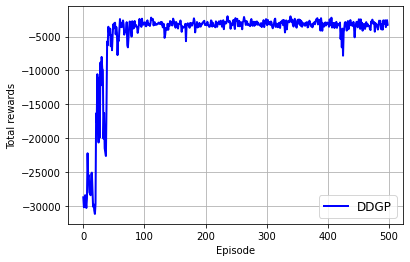

In [2]:
import matplotlib.pyplot as plt
plt.plot(range(len(scores)), np.array(scores), 'b', linewidth = 2, label = 'DDGP')
plt.legend(prop={'size':12})
plt.xlabel('Episode')
plt.ylabel('Total rewards')
#plt.xlim(0, no_of_episodes)
#plt.ylim(0, 20000)
#plt.legend(['Double DQN', 'Dueling DQN', 'D3QN'], loc=4)
plt.grid(True)

In [3]:
# Test
from time import sleep

for n_epi in range(2):
    s = env.reset()
    done = False
        
    while not done:
        a = mu(torch.from_numpy(s).float()) 
        a = a.item() + ou_noise()[0]
        s_prime, r, done, info = env.step([a])
        env.render()
        sleep(0.01)
        score +=r
        s = s_prime
                
        
    if n_epi%print_interval==0 and n_epi!=0:
        print("# of episode :{}, avg score : {:.1f}".format(n_epi, score/print_interval))
        score = 0.0

env.close()